# Assignment 6:   
## Dimensionality reduction and the Project Walkthrough
##### *This assignment is a walkthrough of Geron chapter 2.*

##### Made by:

#### **Jean-Poul Leth-Møller - cph-jl360**

## 1. Frame the problem

Can I make a model that can predict and classify a label when using the iris dataset.  
The following are the classes in the dataset:  
-- Iris Setosa  
-- Iris Versicolour  
-- Iris Virginica
  
This will be done by supervised learning and is categorized as a classification task.
MEsuring the performance of the model will be done with root mean square error (RMSE).


## 2. Setup

In [1]:
# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from pandas.plotting import scatter_matrix
import seaborn as sns
sns.set_style('whitegrid')

# Machine learning
from sklearn.model_selection import train_test_split

try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 3. Get the data

In [2]:
# Url for the dataset
IRIS_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# Method to be load the data into pandas dataframe
def fetch_iris_data():
    return pd.read_csv(IRIS_URL, names=['sepal length','sepal width','petal length','petal width','target'])

In [3]:
df = fetch_iris_data()

#### 3.1 Quick look into the data structure

In [4]:
# Five first rows in the dataset to get a picture of what kind of data I will be working with
df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
# Shape about the dataset
df.shape

(150, 5)

In [6]:
# Overview over all the columns
df.columns

Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'target'], dtype='object')

In [7]:
# Info is used to get a quick description of the data (rows, attribute and number of non-null values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   target        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [8]:
# There are only 150 instances which indicates that this is a very small dataset
# Furthermore I can see that all are numeric values except for the target which is an object, but since i loaded
# this from a text file I know that the value must be a text attribute.

In [9]:
# I will now investigate which categories the target column contains
df['target'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: target, dtype: int64

In [10]:
# I can see that there is three categories 

In [11]:
# To get a summary of the numeric values I will use the desribe() method
df.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [12]:
# Most rows are self-explanatory (count, mean, min, max). Std stands for standard deviation which measures
# how dispersed the values are. 25%, 50% and 75% shows the corresponding percentiles.

array([[<AxesSubplot:title={'center':'sepal length'}>,
        <AxesSubplot:title={'center':'sepal width'}>],
       [<AxesSubplot:title={'center':'petal length'}>,
        <AxesSubplot:title={'center':'petal width'}>]], dtype=object)

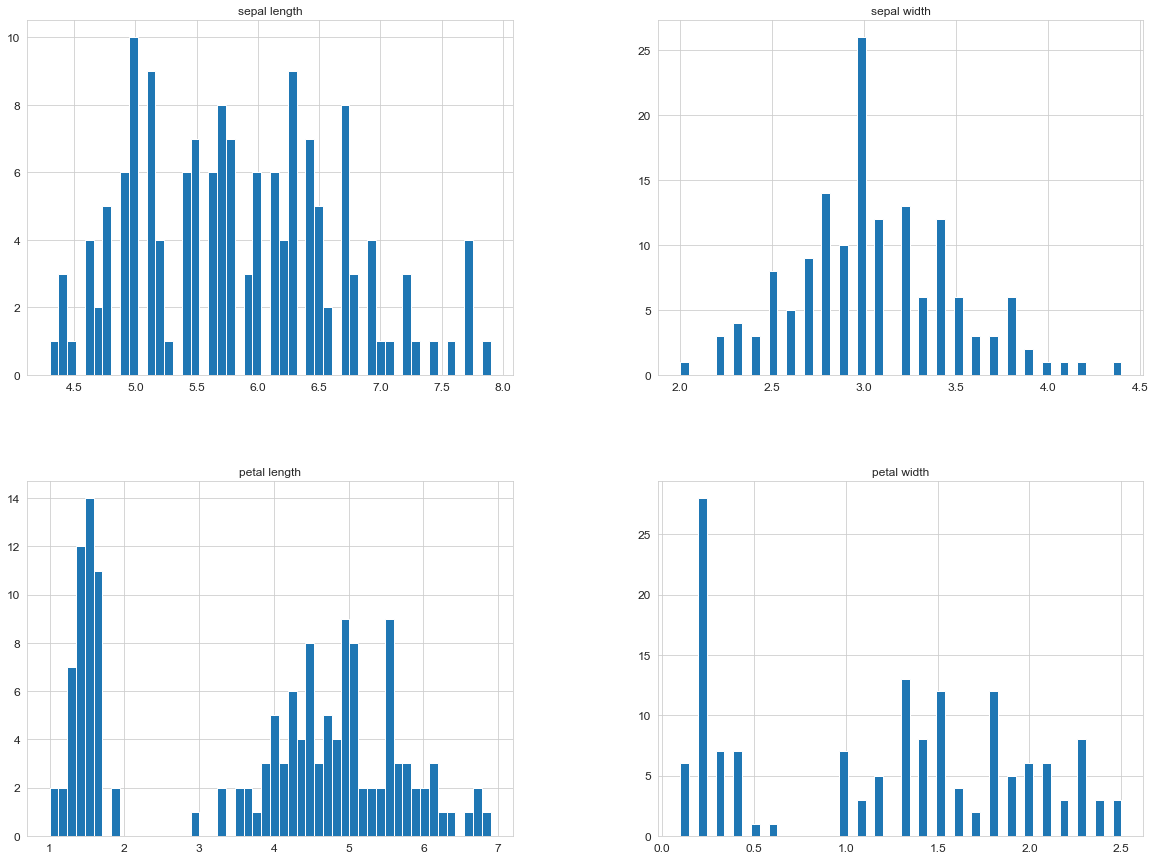

In [13]:
# It is a good idea to visualize the data to better be able to understand relationships and correlations.
# To begin with I will bin the data and show it as a histogram which shows the frequency of the numeric values.
df.hist(bins=50, figsize=(20, 15))

## 4. Creating a training and test set for my model

In [14]:
# I will not be looking into my test data to avoid data snooping bias which can result in a model that doesn't
# as well as expected.
# Typically 20% of the dataset is set aside for testing (which is picked randomly).
# to make sure that the training set wont see or train on the test set random_state is used.

In [15]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [16]:
# To verify that the data has been split correctly.
print("Training dataset (80%):", len(train_set))
print("Test dataset (20%):", len(test_set))

Training dataset (80%): 120
Test dataset (20%): 30


In [17]:
# To avoid sampling bias / skewed data (pick samples randomly) I could have used stratified sampling
# (pick samples that represents the whole data).
# The following library can be used to get stratified sampling:
# from sklearn.model_selection import StratifiedShuffleSplit
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# After this i could compare the stratified dataset with the random dataset to compare sampling bias.

In [18]:
train_set.head()

,sepal length,sepal width,petal length,petal width,target
22,4.6,3.6,1.0,0.2,Iris-setosa
15,5.7,4.4,1.5,0.4,Iris-setosa
65,6.7,3.1,4.4,1.4,Iris-versicolor
11,4.8,3.4,1.6,0.2,Iris-setosa
42,4.4,3.2,1.3,0.2,Iris-setosa


In [19]:
test_set.head()

,sepal length,sepal width,petal length,petal width,target
73,6.1,2.8,4.7,1.2,Iris-versicolor
18,5.7,3.8,1.7,0.3,Iris-setosa
118,7.7,2.6,6.9,2.3,Iris-virginica
78,6.0,2.9,4.5,1.5,Iris-versicolor
76,6.8,2.8,4.8,1.4,Iris-versicolor


<AxesSubplot:>

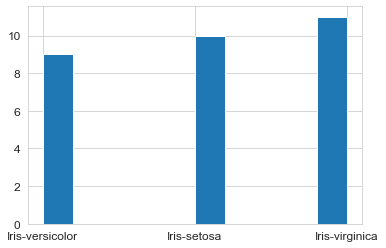

In [20]:
test_set['target'].hist()

## 5. Discover and visualize the data to gain insights

In [21]:
# I will create a copy of the training set to be able to play with the data without harming the original set.
play_df = train_set.copy()

#### 5.1 Visualizing data

C:\Users\jplm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Species Count'}, xlabel='target', ylabel='count'>

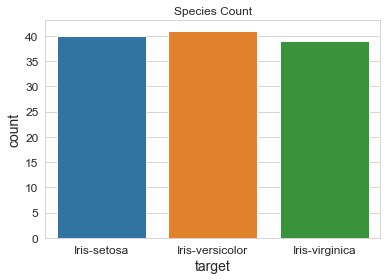

In [22]:
plt.title('Species Count')
sns.countplot(play_df['target'])

In [23]:
# I start by comparing the iris species based on sepal length and width 

Saving figure visualization_plot


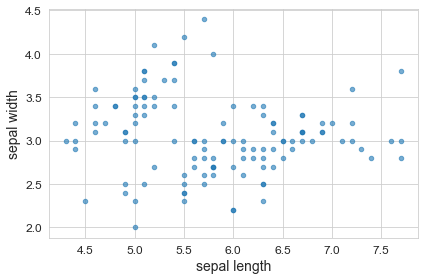

In [24]:
play_df.plot(kind="scatter", x="sepal length", y="sepal width", alpha=0.6)
save_fig("visualization_plot")

Saving figure sepal_width_vs_length_scatterplot


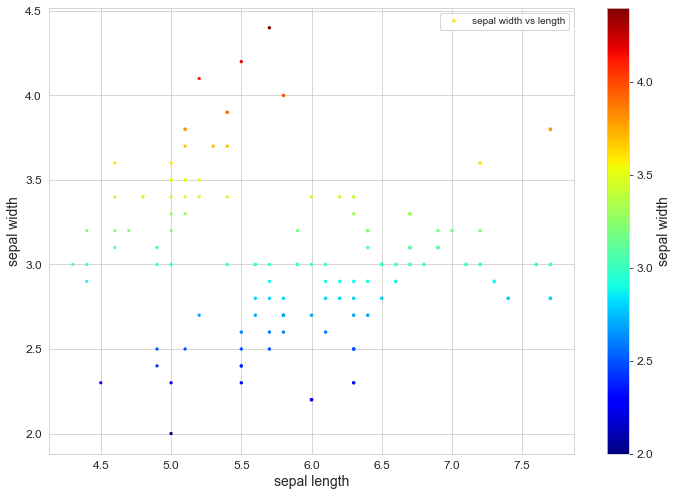

In [25]:
play_df.plot(kind="scatter", x="sepal length", y="sepal width", alpha=1,
    s=play_df["sepal length"], label="sepal width vs length", figsize=(10,7),
    c="sepal width", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("sepal_width_vs_length_scatterplot")

Saving figure petal_width_vs_length_scatterplot


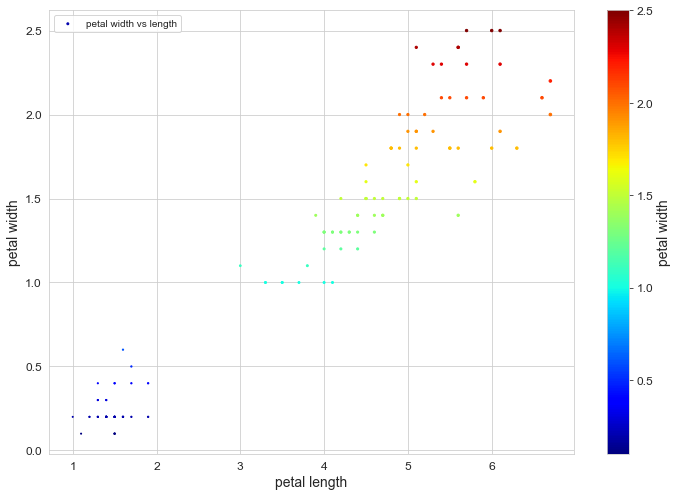

In [26]:
# Then i compare the the iris species based on petal length and width 
play_df.plot(kind="scatter", x="petal length", y="petal width", alpha=1,
    s=play_df["petal length"], label="petal width vs length", figsize=(10,7),
    c='petal width', cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("petal_width_vs_length_scatterplot")

In [27]:
# In this plot the data points are clustered together which can indicate a correlation within the iris species
# (growth in petal length = bigger petal width).

#### 5.2 Looking for correlations

In [28]:
corr_matrix = play_df.corr()

In [29]:
# I will investigate petal length / width since I could see a correlation in the previous plot.

In [30]:
corr_matrix["petal length"].sort_values(ascending=False)

petal length    1.000000
petal width     0.962432
sepal length    0.862183
sepal width    -0.422447
Name: petal length, dtype: float64

In [31]:
# Here I can see that petal length has a strong positive correlation with 
# petal width (0.962432) and sepal length (0.862183).

# The correlation coefficient ranges from -1 to 1.
# When the value is close to 1 it means that there is a strong positive correlation.
# When the value is close to -1 it means that there is a strong negative correlation.

Saving figure scatter_matrix_plot


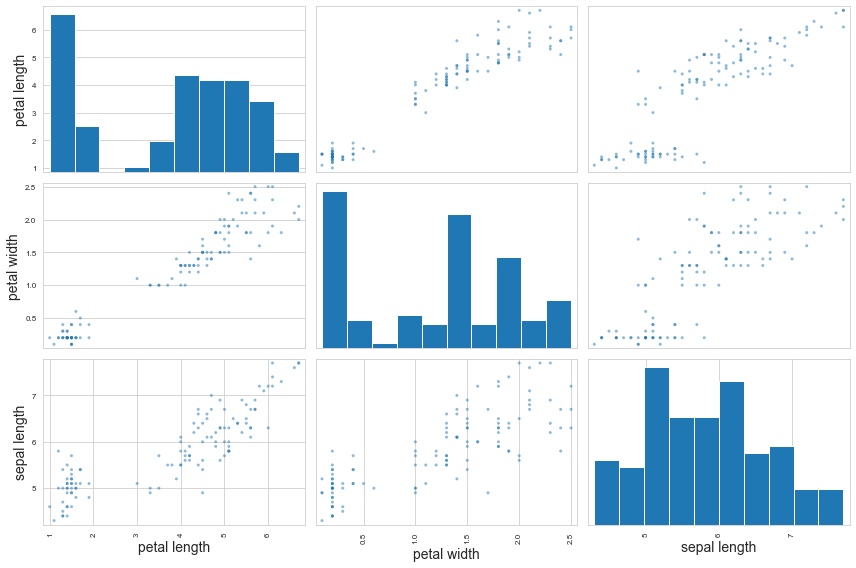

In [32]:
# To visualize this I use pandas plotting
attributes = ["petal length", "petal width", "sepal length"]
scatter_matrix(play_df[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

<AxesSubplot:>

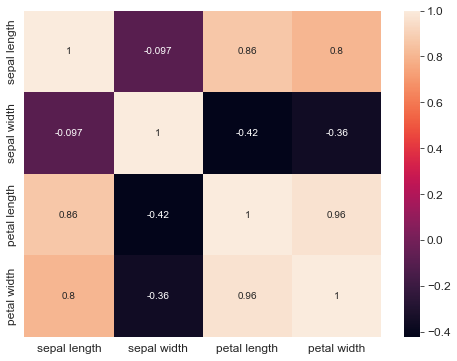

In [33]:
# This can also be visualized with a heatmap
plt.figure(figsize=(8,6))
iris_corr = play_df.corr()
sns.heatmap(iris_corr, annot=True)

In [34]:
# Not only did I find that there is a strong positive correlation with petal length and petal width I can
# also see a strong positive correlation with petal length and sepal length.
# Furthermore I can see a negative correlation with petal length and sepal width.

Saving figure petal_length_vs_petal_width


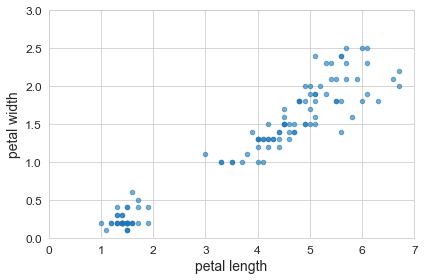

In [35]:
play_df.plot(kind="scatter", x="petal length", y="petal width",
             alpha=0.6)
plt.axis([0, 7, 0, 3])
save_fig("petal_length_vs_petal_width")

<AxesSubplot:xlabel='target', ylabel='sepal width'>

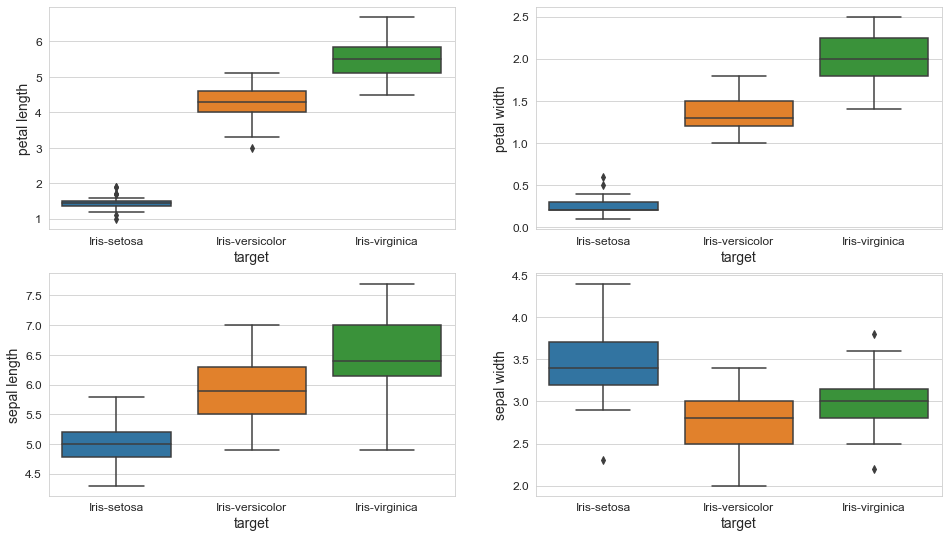

In [36]:
# Finally I am seeing how the data i distributed and watch for outliers.
fig, axes = plt.subplots(2,2, figsize=(16,9))

sns.boxplot(x='target', y='petal length', data=play_df, orient='v', ax=axes[0,0])
sns.boxplot(x='target', y='petal width', data=play_df, orient='v', ax=axes[0,1])
sns.boxplot(x='target', y='sepal length', data=play_df, orient='v', ax=axes[1,0])
sns.boxplot(x='target', y='sepal width', data=play_df, orient='v', ax=axes[1,1])

## 6. Prepare the data for Machine Learning algorithms

In [37]:
# First of I will start by making sure the data is cleaned (not having missing values)
train_set.isnull().sum()

sepal length    0
sepal width     0
petal length    0
petal width     0
target          0
dtype: int64

In [107]:
# Preparing X and y for the machine learning model
array = train_set.values
X = array[:,0:4]

In [108]:
# This combined with the .info() method I used in the beginning of this walkthrough, tells me that the dataset is
# ready for training.
# If I needed to fill some values I could use the .fillna() method.
# SimpleImputer could also have been used:
# try:
#    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
#except ImportError:
#    from sklearn.preprocessing import Imputer as SimpleImputer

In [109]:
# Now that I am working with categorical values in my column 'target' I will have to do one-hot encoding (0 = cold, 1 = hot)
# to better be able to work with machine learning algorithms.
iris_cat = train_set[['target']]
iris_cat.head(10)

,target
22,Iris-setosa
15,Iris-setosa
65,Iris-versicolor
11,Iris-setosa
42,Iris-setosa
146,Iris-virginica
51,Iris-versicolor
27,Iris-setosa
4,Iris-setosa
32,Iris-setosa


In [110]:
cat_encoder = OneHotEncoder()
iris_cat_1hot = cat_encoder.fit_transform(iris_cat)

In [111]:
# The OneHotEncoder returns a sparse array but since I need a dense array I call the toarray() method
iris_cat_1hot.toarray()

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1

In [112]:
# y values for my training set
y = iris_cat_1hot.toarray()

In [113]:
# To be sure I still have the right labels 
cat_encoder.categories_

[array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)]

#### 6.1 Training and evaluating on the training set

In [114]:
# Now that I am ready to try out different kind of algorithms I will start out with LinearRegression and measure
# it's performance
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [165]:
lin_reg.score(X, y)

0.5845893546875128

In [115]:
print("Predictions:", lin_reg.predict(X))

Predictions: [[ 1.06400709  0.00667716 -0.07068425]
 [ 1.2041202  -0.33301799  0.12889779]
 [ 0.22784497  0.36728369  0.40487134]
 [ 0.89378361  0.2053749  -0.09915851]
 [ 0.88671895  0.2368994  -0.12361835]
 [-0.10817456  0.52883693  0.57933763]
 [ 0.21256368  0.29000001  0.49743631]
 [ 0.95922305  0.15168823 -0.11091128]
 [ 0.99752305  0.08407186 -0.08159491]
 [ 1.12320594 -0.08258838 -0.04061756]
 [-0.09953057  0.44236377  0.6571668 ]
 [ 0.24010562  0.14742159  0.61247279]
 [ 0.15764268  0.37696505  0.46539227]
 [ 1.10182786 -0.1443066   0.04247874]
 [ 1.02067399  0.06443931 -0.0851133 ]
 [ 0.16523843  0.70745666  0.1273049 ]
 [-0.02363397  0.57362506  0.45000891]
 [-0.04538969  0.38201724  0.66337244]
 [ 0.19711951  0.41090814  0.39197235]
 [-0.05244493 -0.01677658  1.06922151]
 [ 0.17926616  0.44330538  0.37742846]
 [-0.27020841  0.51892091  0.7512875 ]
 [ 0.1239733   0.36331924  0.51270746]
 [ 0.97584406  0.13233955 -0.10818362]
 [-0.33246433  0.67156155  0.66090278]
 [ 0.1728378

In [116]:
# I will now measure the models root mean square error (RMSE)
iris_predictions = lin_reg.predict(X)
lin_mse = mean_squared_error(y, iris_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.3043102171246007

In [117]:
# I will also look at the absolute error
lin_mae = mean_absolute_error(y, iris_predictions)
lin_mae

0.2403671478790056

In [118]:
# This is a relatively high error when looking at the measurements from our original dataset
# I will now try with another model called Decision tree which is great at finding nonlinear relationships in the data. 

In [119]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(random_state=42)

In [164]:
tree_reg.score(X, y)

1.0

In [120]:
# The model is trained, now I will evaluate
iris_predictions = tree_reg.predict(X)
tree_mse = mean_squared_error(y, iris_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [121]:
# That is a very low error which could indicate that we have a perfect model but it seems it is more likely that the model has badly
# overfittet the data.
# I will now try with a random forest model
forest_reg = RandomForestRegressor()
forest_reg.fit(X, y)

RandomForestRegressor()

In [122]:
forest_reg.score(X, y)

0.9779021405490481

In [123]:
iris_predictions = forest_reg.predict(X)
mse = mean_squared_error(y, iris_predictions)
rmse = np.sqrt(mse)
rmse

0.070059498523279

## 7. Fine-Tune your model

#### 7.1 Standardizing the data

In [124]:
# First of I start with standardizing the data. Data standardization is the process of rescaling one or more attributes so 
# that they have a mean value of 0 and a standard deviation of 1
# Standardizing the features:
x = StandardScaler().fit_transform(X)

#### 7.2 Principal Component Analysis

In [125]:
# Then I use PCA to reduce the dimensions of the dataset to a 2-dimensional dataset
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [128]:
# The result from reducing the dimensions
principalDf

,principal component 1,principal component 2
0,-2.740949,0.452909
1,-2.201668,2.646865
2,0.927518,0.529513
3,-2.294992,0.138398
4,-2.529699,-0.466591
...,...,...
115,0.516707,-0.385241
116,0.404668,-1.533291
117,-2.152237,1.846379
118,0.370140,-0.948073


In [131]:
# Concatenating the PCA result with the label 'target'
finalDf = pd.concat([principalDf, train_set[['target']]], axis = 1)
finalDf

,principal component 1,principal component 2,target
0,-2.740949,0.452909,Iris-setosa
1,-2.201668,2.646865,Iris-setosa
2,0.927518,0.529513,Iris-setosa
3,-2.294992,0.138398,Iris-setosa
4,-2.529699,-0.466591,Iris-setosa
...,...,...,...
144,NaN,NaN,Iris-virginica
146,NaN,NaN,Iris-virginica
147,NaN,NaN,Iris-virginica
148,NaN,NaN,Iris-virginica


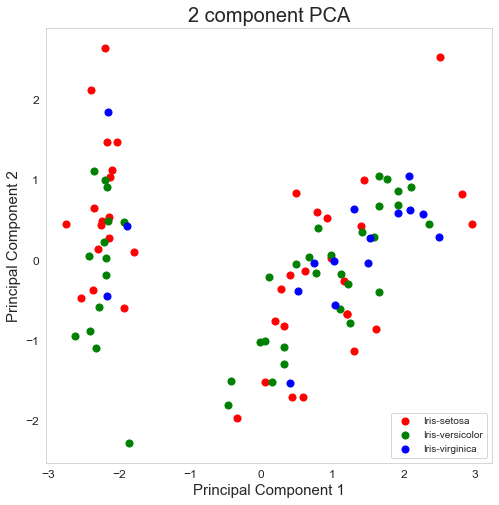

In [132]:
# Visualizing my new PCA dataset
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [133]:
# Getting an overview of the data spread in %
pca.explained_variance_ratio_

array([0.72317687, 0.23215265])

In [154]:
# Make an instance of the PCA Model with a variance ration of 95%
pca = PCA(.95)

In [155]:
pca.fit(x)

PCA(n_components=0.95)

#### 7.3 Comparison of the model with and without PCA

In [156]:
# Preparing X_test for the machine learning model
array = test_set.values
X_test = array[:,0:4]

In [157]:
train_pca = pca.transform(x)
test_pca = pca.transform(X_test)

In [142]:
# Making and instance of the random forest model
forest_reg_with_pca = RandomForestRegressor()

In [158]:
# Using PCA dataset to train the new model
forest_reg_with_pca.fit(train_pca, y)

RandomForestRegressor()

In [159]:
# Using my test data to predict and measuring my RMSE
forest_predictions = forest_reg_with_pca.predict(test_pca)
mse = mean_squared_error(y, iris_predictions)
rmse = np.sqrt(mse)
rmse

0.070059498523279

In [160]:
# Same score as with the data without PCA
forest_reg_with_pca.score(train_pca, y)

0.9749882745320294

#### 7.4 Time measurement on datasets

In [161]:
# First of I start with timing the random forest model without PCA
%timeit forest_reg.fit(x, y)

84.1 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [162]:
# Thereafter I time the same model but with the PCA reduced data
%timeit forest_reg_with_pca.fit(train_pca, y)

82.1 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 8. Conclusion

I can not see a reduction in time when running my models which can indicate that PCA is not helpful in my case. In theory my model should run faster but since PCA is used to reduce dimensions in large datasets I can only conclude that the dataset is to small to make any real optimization. Out of the three models I have trained I can conclude that DecisionTree was the one that had the highest score, however this can be the result of overfitting which I could see with a RMSE of 0.0.